# Домашнее задание по теме "Функции потерь и оптимизация"

<pre>
ФИО: Никифоров Владимир
</pre>

* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

In [2]:
iris = datasets.load_iris()
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [3]:
# Сделаем в виде пандас-фрейма
df = pd.concat([pd.DataFrame(data=iris.data,columns=['c1','c2','c3','c4']),pd.DataFrame(data=iris.target,columns=['target'])],axis=1)
# Оставим лишь нужные нам классы Versicolor и Virginica, т.е. где target != 0
df = df[df['target']!=0]
# Для бинарной классификации превратим классы 1 и 2 в классы 0 и 1
df['target'] = df['target'] - 1
df.head()

,c1,c2,c3,c4,target
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [4]:
X, Y = df.drop('target',axis=1).values, df['target'].values

In [5]:
X, Y

(array([[7. , 3.2, 4.7, 1.4],
        [6.4, 3.2, 4.5, 1.5],
        [6.9, 3.1, 4.9, 1.5],
        [5.5, 2.3, 4. , 1.3],
        [6.5, 2.8, 4.6, 1.5],
        [5.7, 2.8, 4.5, 1.3],
        [6.3, 3.3, 4.7, 1.6],
        [4.9, 2.4, 3.3, 1. ],
        [6.6, 2.9, 4.6, 1.3],
        [5.2, 2.7, 3.9, 1.4],
        [5. , 2. , 3.5, 1. ],
        [5.9, 3. , 4.2, 1.5],
        [6. , 2.2, 4. , 1. ],
        [6.1, 2.9, 4.7, 1.4],
        [5.6, 2.9, 3.6, 1.3],
        [6.7, 3.1, 4.4, 1.4],
        [5.6, 3. , 4.5, 1.5],
        [5.8, 2.7, 4.1, 1. ],
        [6.2, 2.2, 4.5, 1.5],
        [5.6, 2.5, 3.9, 1.1],
        [5.9, 3.2, 4.8, 1.8],
        [6.1, 2.8, 4. , 1.3],
        [6.3, 2.5, 4.9, 1.5],
        [6.1, 2.8, 4.7, 1.2],
        [6.4, 2.9, 4.3, 1.3],
        [6.6, 3. , 4.4, 1.4],
        [6.8, 2.8, 4.8, 1.4],
        [6.7, 3. , 5. , 1.7],
        [6. , 2.9, 4.5, 1.5],
        [5.7, 2.6, 3.5, 1. ],
        [5.5, 2.4, 3.8, 1.1],
        [5.5, 2.4, 3.7, 1. ],
        [5.8, 2.7, 3.9, 1.2],
        [6

In [6]:
EPOCHS = 1000
LEARNING_RATE = 0.01
RANDOM_STATE = 7

Наш sigmoid:

$${\displaystyle \sigma (x)={\frac {1}{1+e^{-x}}}.}$$

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def sigmoid_derivative(x):
    return np.exp(-x)/((1 + np.exp(-x))**2)

Наш loss = cost_function:

$$J = -\sum_{i=1}^{N} y_i\log (h_\theta(x_i)) + (1 - y_i)\log(1 - h_\theta(x_i))$$

In [8]:
def cost_function(Y_label, Y_pred):
    return - np.sum((Y_label * np.log(Y_pred)) + ((1. - Y_label) * np.log(1. - Y_pred)))

In [9]:
def der_theta0(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i])
    return total_cost / (len(X))

In [10]:
def der_theta1(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,0]
    return total_cost / (len(X))

In [11]:
def der_theta2(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,1]
    return total_cost / (len(X))

In [12]:
def der_theta3(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,2]
    return total_cost / (len(X))

In [13]:
def der_theta4(X, y, theta0, theta1, theta2, theta3, theta4):
    total_cost = 0
    for i in range(len(X)):
        total_cost += (sigmoid(theta0 + theta1*X[i,0] + theta2*X[i,1] + theta3*X[i,2] + theta4*X[i,3]) - y[i]) * X[i,3]
    return total_cost / (len(X))

In [14]:
def train_model(X, Y, epochs=EPOCHS, lr=LEARNING_RATE):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    for e in range(epochs):
        dt0 = der_theta0(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X, Y, theta0, theta1, theta2, theta3, theta4)

        theta0 -= lr * dt0
        theta1 -= lr * dt1
        theta2 -= lr * dt2
        theta3 -= lr * dt3
        theta4 -= lr * dt4

        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [15]:
theta0, theta1, theta2, theta3, theta4 = train_model(X, Y)
theta0, theta1, theta2, theta3, theta4

EPOCH: 0 t0: 0.9950000028980888 t1: 0.9703200156146312 t2: 0.9861500071636035 t3: 0.9787000108456427 t4: 0.9933700033714434 cost: 748.6463289176013
EPOCH: 1 t0: 0.9900000067593974 t1: 0.9406400364650563 t2: 0.9723000167294161 t3: 0.9574000253512468 t4: 0.98674000788271 cost: 732.6926348901727
EPOCH: 2 t0: 0.9850000119080672 t1: 0.9109600643299078 t2: 0.9584500295134836 t3: 0.9361000447685853 t4: 0.9801100139245561 cost: 716.7389489416782
EPOCH: 3 t0: 0.9800000187787761 t1: 0.8812801016004305 t2: 0.9446000466128947 t3: 0.914800070783666 t4: 0.9734800220236819 cost: 700.7852738489302
EPOCH: 4 t0: 0.975000027954965 t1: 0.8516001514945645 t2: 0.9307500695039734 t3: 0.8935001056696106 t4: 0.9668500328907584 cost: 684.8316133317975
EPOCH: 5 t0: 0.9700000402204807 t1: 0.8219202183469811 t2: 0.9169001001752944 t3: 0.8722001524941896 t4: 0.9602200474856937 cost: 668.8779724096466
EPOCH: 6 t0: 0.9650000566294143 t1: 0.7922403080024364 t2: 0.903050141308061 t3: 0.8509002154018614 t4: 0.9535900671

(0.44654888591269765,
 -0.993322083405769,
 -0.22329490809539176,
 0.8653913941715192,
 1.3732456566170808)

In [16]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]

In [17]:
# Полученная точность модели:
accuracy_score(y_true=Y, y_pred=Y_pred)

0.95

In [18]:
# проверим обучение при разбиении на тренировочную и тестовую части
# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target',axis=1).values, df['target'].values, random_state=RANDOM_STATE, test_size=0.3)

In [19]:
def train_and_test_model(X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LEARNING_RATE):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    scores_train = []
    scores_test = []
    for e in range(epochs):
        dt0 = der_theta0(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X_train, y_train, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X_train, y_train, theta0, theta1, theta2, theta3, theta4)

        theta0 -= lr * dt0
        theta1 -= lr * dt1
        theta2 -= lr * dt2
        theta3 -= lr * dt3
        theta4 -= lr * dt4
        score_train = cost_function(y_train, sigmoid(theta0 + theta1*X_train[:,0] + theta2*X_train[:,1] + theta3*X_train[:,2] + theta4*X_train[:,3]))
        score_test = cost_function(y_test, sigmoid(theta0 + theta1*X_test[:,0] + theta2*X_test[:,1] + theta3*X_test[:,2] + theta4*X_test[:,3]))
        scores_train.append(score_train)
        scores_test.append(score_test)
        #print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost_train:", score_train, "cost_test:", score_test)
    
    plt.plot(range(epochs), scores_train, c='b')
    plt.scatter(range(epochs), scores_test, c='y')
    best_point = np.argmin(scores_test)
    plt.scatter(range(epochs)[best_point], scores_test[best_point], c='g', s=100)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title("Cost vs Epochs")
    plt.legend(['train','test'])
    return theta0, theta1, theta2, theta3, theta4

(-0.8668019522013555,
 -2.405781569836453,
 -2.418995324014585,
 3.599642816212361,
 3.2710390500443522)

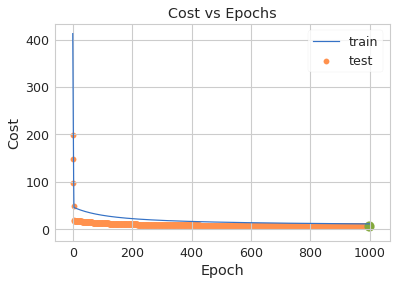

In [20]:
theta0, theta1, theta2, theta3, theta4 = train_and_test_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, lr=0.1)
theta0, theta1, theta2, theta3, theta4

In [21]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
# Опять же сумасшедшая точность:
accuracy_score(y_true=Y, y_pred=Y_pred)

0.96

## Nesterov Accelerated Gradient

In [22]:
LEARNING_RATE = 0.1

In [23]:
def train_model_NM(X, Y, gamma=0.9, lr=LEARNING_RATE):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    v = [0]*5
    for e in range(EPOCHS):
        dt0 = der_theta0(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X, Y, theta0, theta1, theta2, theta3, theta4)

        v[0] = gamma*v[0] + lr*dt0
        v[1] = gamma*v[1] + lr*dt1
        v[2] = gamma*v[2] + lr*dt2
        v[3] = gamma*v[3] + lr*dt3
        v[4] = gamma*v[4] + lr*dt4
        
        theta0 -= v[0]
        theta1 -= v[1]
        theta2 -= v[2]
        theta3 -= v[3]
        theta4 -= v[4]
    
        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [24]:
theta0, theta1, theta2, theta3, theta4 = train_model_NM(X, Y)
theta0, theta1, theta2, theta3, theta4

EPOCH: 0 t0: 0.9500000289808874 t1: 0.7032001561463125 t2: 0.8615000716360344 t3: 0.7870001084564273 t4: 0.9337000337144343 cost: 605.0634333808018
EPOCH: 1 t0: 0.8550005853872804 t1: 0.13928322423496742 t2: 0.5983514790787317 t3: 0.38230227550919677 t4: 0.8077307114676091 cost: 302.11921942378996
EPOCH: 2 t0: 0.7196761386146241 t1: -0.6640169927890863 t2: 0.22348618122909192 t3: -0.1941704636792871 t4: 0.6283003618166698 cost: 146.79265916158425
EPOCH: 3 t0: 0.6411305262615282 t1: -1.098493332046664 t2: 0.015611011052735518 t3: -0.4673621562095816 t4: 0.5569737183650038 cost: 400.85989699375415
EPOCH: 4 t0: 0.6203637469086278 t1: -1.1605581481625318 t2: -0.022982475156217236 t3: -0.43596462742027786 t4: 0.5939679837782846 cost: 415.598626067384
EPOCH: 5 t0: 0.6516170335510127 t1: -0.8873419842923356 t2: 0.09082973002362116 t3: -0.13035357367300981 t4: 0.7284791193418128 cost: 210.5230678953738
EPOCH: 6 t0: 0.7278391969793814 t1: -0.3234622454154007 t2: 0.33658991258160914 t3: 0.413356

(-4.890281640917401,
 -4.182268148608614,
 -4.520492259918793,
 6.251920488097422,
 7.961482791168799)

In [25]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
accuracy_score(y_true=Y, y_pred=Y_pred)

0.96

## RMSProp

In [26]:
def train_model_RMSProp(X, Y, gamma=0.9, lr=LEARNING_RATE, eps=0.00001):
    theta0 = 1
    theta1 = 1
    theta2 = 1
    theta3 = 1
    theta4 = 1
    EG = [0]*5
    for e in range(EPOCHS):
        dt0 = der_theta0(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt1 = der_theta1(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt2 = der_theta2(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt3 = der_theta3(X, Y, theta0, theta1, theta2, theta3, theta4)
        dt4 = der_theta4(X, Y, theta0, theta1, theta2, theta3, theta4)

        EG[0] = gamma*EG[0] + (1-gamma)*(dt0**2)
        EG[1] = gamma*EG[1] + (1-gamma)*(dt1**2)
        EG[2] = gamma*EG[2] + (1-gamma)*(dt2**2)
        EG[3] = gamma*EG[3] + (1-gamma)*(dt3**2)
        EG[4] = gamma*EG[4] + (1-gamma)*(dt4**2)
        
        theta0 -= lr * dt0/np.sqrt(EG[0]+eps)
        theta1 -= lr * dt1/np.sqrt(EG[1]+eps)
        theta2 -= lr * dt2/np.sqrt(EG[2]+eps)
        theta3 -= lr * dt3/np.sqrt(EG[3]+eps)
        theta4 -= lr * dt4/np.sqrt(EG[4]+eps)
    
        print("EPOCH:", e, "t0:", theta0, "t1:", theta1, "t2:", theta2, "t3:", theta3, "t4:", theta4, "cost:", cost_function(Y, sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])))
    return theta0, theta1, theta2, theta3, theta4

In [27]:
theta0, theta1, theta2, theta3, theta4 = train_model_RMSProp(X, Y, lr=0.05)
theta0, theta1, theta2, theta3, theta4

EPOCH: 0 t0: 0.8419177303211471 t1: 0.8418870144389214 t2: 0.8418902381938589 t3: 0.8418878594967086 t4: 0.8419040990457315 cost: 643.7103677992983
EPOCH: 1 t0: 0.7272221887918789 t1: 0.7271797240870459 t2: 0.7271841753997704 t3: 0.7271808879739468 t4: 0.727203330478576 cost: 556.0075036764536
EPOCH: 2 t0: 0.6311833659276936 t1: 0.6311339267683067 t2: 0.6311390830302861 t3: 0.631135273854637 t4: 0.6311613768805568 cost: 482.5756412278175
EPOCH: 3 t0: 0.5459323946637658 t1: 0.5458778550741168 t2: 0.5458834501877611 t3: 0.5458793691749951 t4: 0.545908144585625 cost: 417.40276583083954
EPOCH: 4 t0: 0.467822411342473 t1: 0.4677634244762816 t2: 0.46776918881761864 t3: 0.46776535967755856 t4: 0.4677966959139228 cost: 357.7183969729965
EPOCH: 5 t0: 0.3948430751568951 t1: 0.3947794538316995 t2: 0.3947848574523899 t3: 0.39478309982322257 t4: 0.3948184920708426 cost: 302.0373935287126
EPOCH: 6 t0: 0.32580509781750827 t1: 0.3257362572624532 t2: 0.325739904382265 t3: 0.32574664351626875 t4: 0.3257

(-8.900136857467581,
 -2.3413317221108794,
 -3.722318253351055,
 4.258347824164411,
 8.251010496536079)

In [28]:
Y_pred = sigmoid(theta0 + theta1*X[:,0] + theta2*X[:,1] + theta3*X[:,2] + theta4*X[:,3])
Y_pred = [0 if y < 0.5 else 1 for y in Y_pred]
# Точность случайного классификатора:)
accuracy_score(y_true=Y, y_pred=Y_pred)

0.97

Заметим, что за 1000 эпох RMSprop и Nesterov Accelerated Gradient сошлись к лучшему минимуму. То есть этим алгоритмам требуется меньше эпох для достижения минимума, чем обычному градиентному спуску. А RMSProp получил за 1000 эпох еще и лучше качество, чем Nesterov.